In [1]:
! pip install numpy==1.26.4
! pip install torch==1.13.1+cu116 torchvision==0.14.1+cu116 --extra-index-url https://download.pytorch.org/whl/cu116
! pip install matplotlib
! pip install pandas
! pip install scipy

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116


In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
from torch.utils.data import DataLoader
from PIL import Image
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import dice

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
image_folder = 'a0-2025-medical-image-segmentation/Dataset/Train/Image/'
mask_folder = 'a0-2025-medical-image-segmentation/Dataset/Train/Mask/'

In [5]:
# Standard normalization values used for ImageNet models
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

input_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])
target_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [6]:
images = []
for filename in os.listdir(image_folder):
    img_path = os.path.join(image_folder, filename)
    if os.path.isfile(img_path):
        image = Image.open(img_path).convert('RGB')
        image = input_transform(image)
        images.append(image)
image_tensors = torch.stack(images)

In [7]:
masks = []
for filename in os.listdir(mask_folder):
    img_path = os.path.join(mask_folder, filename)
    if os.path.isfile(img_path):
        mask = Image.open(img_path)
        mask = target_transform(mask)
        masks.append(mask)
mask_tensors = torch.stack(masks)

In [8]:
train_set = torch.utils.data.TensorDataset(image_tensors, mask_tensors)

In [9]:
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)

In [10]:
model = deeplabv3_resnet50(weights=None, weights_backbone=torchvision.models.ResNet50_Weights.DEFAULT, num_classes=2, aux_loss=True).to(device)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [12]:
epochs = 50

In [13]:
model.train()
for epoch in range(epochs):
    losses_epoch = 0
    for imgs, masks in train_loader:
        imgs = imgs.to(device)
        masks = masks.squeeze(1).long().to(device)

        outputs = model(imgs)

        loss = criterion(outputs['out'], masks)
        if 'aux' in outputs:
            aux_loss = criterion(outputs['aux'], masks)
            loss += 0.4 * aux_loss  # typical weight for aux loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses_epoch += loss.item()

    print(f"Epoch {epoch+1}, Loss: {losses_epoch:.4f}")

Epoch 1, Loss: 80.9501
Epoch 2, Loss: 59.4493
Epoch 3, Loss: 54.9532
Epoch 4, Loss: 49.2166
Epoch 5, Loss: 45.9709
Epoch 6, Loss: 38.7486
Epoch 7, Loss: 35.9600
Epoch 8, Loss: 33.0069
Epoch 9, Loss: 45.4520
Epoch 10, Loss: 36.2564
Epoch 11, Loss: 30.2695
Epoch 12, Loss: 54.0676
Epoch 13, Loss: 36.0749
Epoch 14, Loss: 34.6968
Epoch 15, Loss: 32.9710
Epoch 16, Loss: 28.6278
Epoch 17, Loss: 26.1721
Epoch 18, Loss: 25.8379
Epoch 19, Loss: 26.5543
Epoch 20, Loss: 30.5619
Epoch 21, Loss: 36.0467
Epoch 22, Loss: 29.8900
Epoch 23, Loss: 25.4612
Epoch 24, Loss: 24.5687
Epoch 25, Loss: 21.0678
Epoch 26, Loss: 20.7299
Epoch 27, Loss: 19.8113
Epoch 28, Loss: 19.7854
Epoch 29, Loss: 22.3855
Epoch 30, Loss: 37.1717
Epoch 31, Loss: 24.9273
Epoch 32, Loss: 20.8527
Epoch 33, Loss: 18.0680
Epoch 34, Loss: 16.6883
Epoch 35, Loss: 16.2766
Epoch 36, Loss: 14.8754
Epoch 37, Loss: 38.2412
Epoch 38, Loss: 24.4058
Epoch 39, Loss: 18.0276
Epoch 40, Loss: 15.2929
Epoch 41, Loss: 14.3946
Epoch 42, Loss: 13.2700
E

In [14]:
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [15]:
preds = torch.zeros(1, 224, 224)
truths = torch.zeros(1, 1, 224, 224)
with torch.no_grad():
    for imgs, masks in train_loader:
        preds = torch.cat((preds, torch.argmax(model(imgs.to(device))['out'].cpu(), dim=1)), 0)
        truths = torch.cat((truths, masks), 0)

preds = preds[1:]
truths = truths[1:].squeeze()

In [16]:
def dice_coef(y_true, y_pred):
    num_images = len(y_true)
    dice_avg = 0
    for i in range(num_images):
        y_true_f = y_true[i].flatten()
        y_pred_f = y_pred[i].flatten()
        # intersection = np.sum(y_true_f * y_pred_f)
        # dice_avg += (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f))
        dice_avg += (1 - dice(y_true_f, y_pred_f))
    return dice_avg / num_images

In [17]:
dice_coef(truths.numpy(), preds.numpy())

0.9681092647604158

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9852941..2.622571].


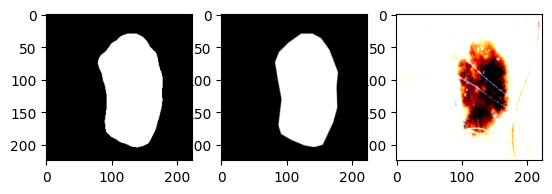

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5455182..1.4199566].


0.9819290644779229


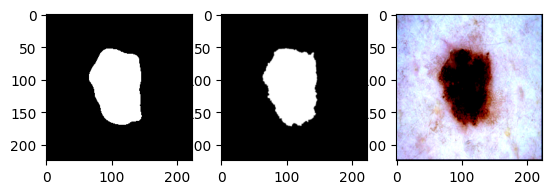

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7064052..1.0713727].


0.9686234254454706


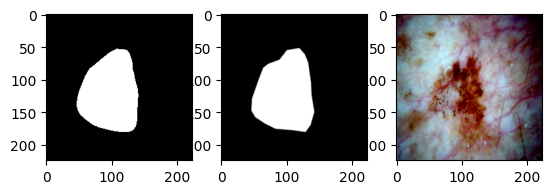

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.230392..1.6813945].


0.9762485577459099


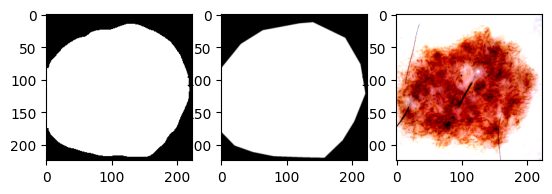

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0203081..0.98422676].


0.9845008884306319


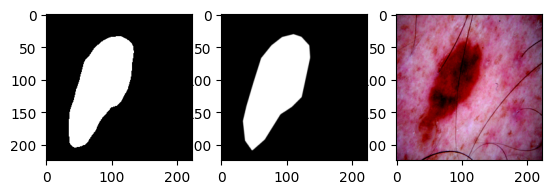

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6680672..2.3611329].


0.9741003662688437


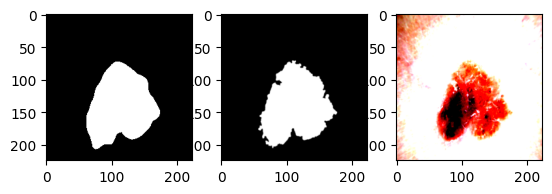

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7695861..1.9406626].


0.9668955982699762


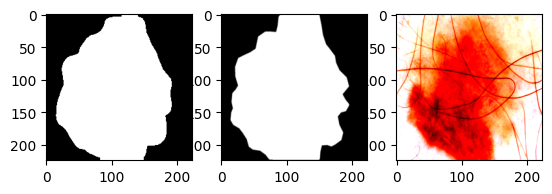

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7411594..2.64].


0.9788688777580228


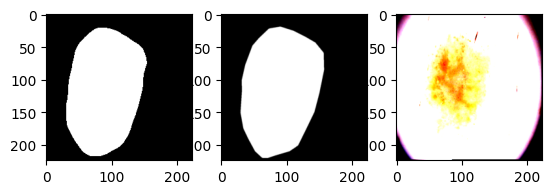

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7205882..2.622571].


0.9703221049433076


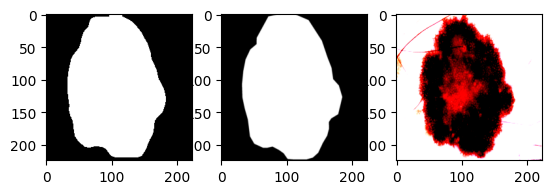

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7205882..1.2282355].


0.9859523062292991


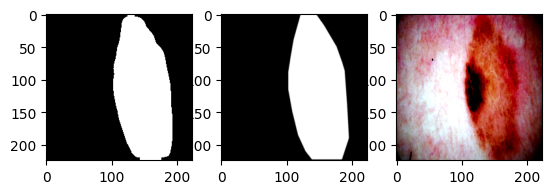

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.370448..1.2108063].


0.9781011172159173


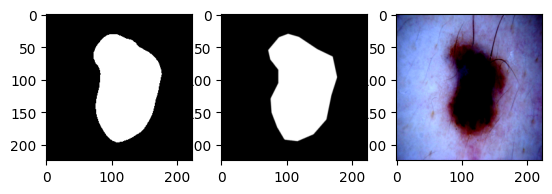

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1072767..1.8333333].


0.9777111523059491


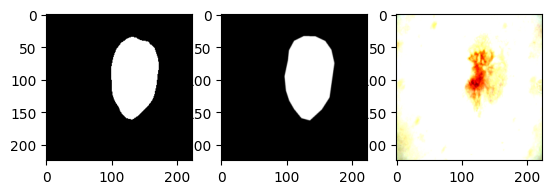

0.9663841440790975


In [18]:
with torch.no_grad():
    for i, (imgs, masks) in enumerate(train_loader):
        imgs = imgs.to(device)
        outputs = model(imgs)['out']

        for j in range(min(4, imgs.size(0))):
            plt.subplot(131)
            pred_mask = torch.argmax(outputs[j], dim=0).cpu().numpy()
            plt.imshow(pred_mask, cmap='gray')
            plt.subplot(132)
            truth_mask = masks.squeeze().cpu().numpy()[j]
            plt.imshow(truth_mask, cmap='gray')
            plt.subplot(133)
            plt.imshow(imgs.permute(0, 2, 3, 1).cpu().numpy()[j])
            plt.show()
            print(1 - dice(truth_mask.flatten(), pred_mask.flatten()))

        if i == 2:
            break

In [19]:
dice_sum = 0
i = 0

for filename in os.listdir(image_folder):
    img_path = os.path.join(image_folder, filename)
    image = Image.open(img_path).convert('RGB')
    orig_width, orig_height = image.size

    image = transforms.Resize((224, 224))(image)
    image = transforms.ToTensor()(image)
    image = transforms.Normalize(mean=imagenet_mean, std=imagenet_std)(image)

    with torch.no_grad():
        pred_mask_tensor = torch.argmax(model(image.unsqueeze(0).to(device))['out'].squeeze(), dim=0).cpu().to(torch.uint8)

    pred_mask = transforms.functional.to_pil_image(pred_mask_tensor)
    pred_mask = np.array(transforms.Resize((orig_height, orig_width))(pred_mask))

    mask_path = os.path.join(mask_folder, re.sub(r"jpg", "png", filename))
    truth_mask = np.array(Image.open(mask_path))
    truth_mask = np.where(truth_mask == 255, 1, 0)

    dice_sum += (1 - dice(truth_mask.flatten(), pred_mask.flatten()))
    i += 1

dice_avg = dice_sum / i

In [20]:
dice_avg

0.968541154154418

test data

In [21]:
def mask_to_rle(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return " ".join(map(str, runs))

In [22]:
test_image_folder = 'a0-2025-medical-image-segmentation/Dataset/Test/Image/'

df_submission = pd.DataFrame(columns=['ID', 'MASK'])

for filename in os.listdir(test_image_folder):
    img_path = os.path.join(test_image_folder, filename)
    image = Image.open(img_path).convert('RGB')
    orig_width, orig_height = image.size

    image = transforms.Resize((224, 224))(image)
    image = transforms.ToTensor()(image)
    image = transforms.Normalize(mean=imagenet_mean, std=imagenet_std)(image)

    with torch.no_grad():
        pred_mask_tensor = torch.argmax(model(image.unsqueeze(0).to(device))['out'].squeeze(), dim=0).cpu().to(torch.uint8)

    pred_mask_image = transforms.functional.to_pil_image(pred_mask_tensor)
    pred_mask_image = np.array(transforms.Resize((orig_height, orig_width))(pred_mask_image))
    pred_mask_rle = mask_to_rle(pred_mask_image)

    id = filename.split('.')[0]
    df_submission = pd.concat([df_submission, pd.DataFrame([[id, pred_mask_rle]], columns=df_submission.columns)], ignore_index=True)

df_submission.to_csv('submission.csv', index=False)

validation run

In [23]:
train_ds, val_ds = torch.utils.data.random_split(train_set, [0.8, 0.2])

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=4)

model = deeplabv3_resnet50(weights=None, weights_backbone=torchvision.models.ResNet50_Weights.DEFAULT, num_classes=2, aux_loss=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
    model.train()
    losses_epoch = 0
    for imgs, masks in train_dl:
        imgs = imgs.to(device)
        masks = masks.squeeze(1).long().to(device)
        outputs = model(imgs)
        loss = criterion(outputs['out'], masks)
        if 'aux' in outputs:
            aux_loss = criterion(outputs['aux'], masks)
            loss += 0.4 * aux_loss  # typical weight for aux loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses_epoch += loss.item()
    print(f"Epoch {epoch+1}, Loss: {losses_epoch:.4f}")
    model.eval()
    with torch.no_grad():
        valid_loss = sum(criterion(model(X.to(device))['out'], y.squeeze(1).long().to(device)).item() for X, y in val_dl)
    print('epoch {}, validation loss {}'.format(epoch+1, valid_loss))

model.eval()

preds = torch.zeros(1, 224, 224)
truths = torch.zeros(1, 1, 224, 224)
with torch.no_grad():
    for imgs, masks in val_dl:
        preds = torch.cat((preds, torch.argmax(model(imgs.to(device))['out'].cpu(), dim=1)), 0)
        truths = torch.cat((truths, masks), 0)
preds = preds[1:]
truths = truths[1:].squeeze()

dice_coef(truths.numpy(), preds.numpy())

Epoch 1, Loss: 68.3911
epoch 1, validation loss 6.7952788062393665
Epoch 2, Loss: 51.1978
epoch 2, validation loss 6.7602055706083775
Epoch 3, Loss: 46.2967
epoch 3, validation loss 8.987273130565882
Epoch 4, Loss: 46.4522
epoch 4, validation loss 5.363442279398441
Epoch 5, Loss: 39.7431
epoch 5, validation loss 7.509067205712199
Epoch 6, Loss: 35.8104
epoch 6, validation loss 4.670609097927809
Epoch 7, Loss: 34.6682
epoch 7, validation loss 5.271727804094553
Epoch 8, Loss: 29.8491
epoch 8, validation loss 4.750957649201155
Epoch 9, Loss: 40.2297
epoch 9, validation loss 5.404415979981422
Epoch 10, Loss: 29.9644
epoch 10, validation loss 4.920699957758188
Epoch 11, Loss: 26.9343
epoch 11, validation loss 14.111650636419654
Epoch 12, Loss: 33.3926
epoch 12, validation loss 5.4543532859534025
Epoch 13, Loss: 27.5484
epoch 13, validation loss 5.316012965515256
Epoch 14, Loss: 27.2931
epoch 14, validation loss 5.071617502719164
Epoch 15, Loss: 22.5383
epoch 15, validation loss 4.9332290180

0.9170018033122407